# Finance: Portfolio Optimization

## Introduction

In this notebook we show how to solve a mean-variance portfolio optimization problem for $n$ assets.

Portfolios can be analyzed in a mean-variance framework, with every investor holding the portfolio with the lowest possible return variance consistent with that investor's chosen level of expected return (called a minimum-variance portfolio), if the returns on the assets are jointly elliptically distributed, including the special case in which they are jointly normally distributed. Under mean-variance analysis, it can be shown that every minimum-variance portfolio given a particular expected return (that is, every efficient portfolio) can be formed as a combination of any two efficient portfolios. If the investor's optimal portfolio has an expected return that is between the expected returns on two efficient benchmark portfolios, then that investor's portfolio can be characterized as consisting of positive quantities of the two benchmark portfolios.

## Define problem

Here an Operator instance is created for our Hamiltonian. In this case the paulis are from an Ising Hamiltonian translated from the portfolio problem. We are gooing to use actual stock-market time series from a number of common providers.

In [1]:
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance import QiskitFinanceError
from qiskit_finance.data_providers import WikipediaDataProvider
from qiskit.utils import algorithm_globals
import numpy as np
import datetime
import matplotlib.pyplot as plt

## Using real financial data

While the access to real-time data usually requires a payment, it is possible to access historical (adjusted) closing prices via Wikipedia and Quandl free of charge, following registration at: https://www.quandl.com/?modal=register. Once you have your token use it to set the variable `quandl_token`.

In [2]:
quandl_token = "HRXZqqxBka_9huabBgoW"

#quandl_token = ""   # Your token here

Let's take $n = 5$ assets for this example, to do this, in variable `stocks` we put 5 NASDAQ issues, and request their time-series:

In [3]:
#stocks = [ "AAPL", "F", "NFLX", "AMZN", "IBM"]  # NASDAQ codes
stocks = [ "AAPL", "IBM", "AMZN"]  # NASDAQ codes
try:
    wiki = WikipediaDataProvider(
                     token = quandl_token,
                     tickers = stocks,
                     start = datetime.datetime(2016,4,1),
                     end = datetime.datetime(2016,5,30))
    wiki.run()
except QiskitFinanceError as ex:
    print(ex)
    print("Error retrieving data.")

### Plot the time-series

Let's take a look into the underlying time-series:

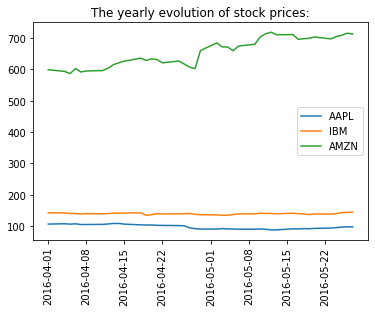

In [4]:
if wiki._data:
    for (cnt, s) in enumerate(stocks):
        plt.plot(wiki._data[cnt], label=s)
    plt.legend()
    plt.title("The yearly evolution of stock prices:")
    plt.xticks(rotation=90)
    plt.show()
else:
    print('No wiki data loaded.')

As all assets must have the same order of magnitude in their prices, the data must be normalized, let's look at the following plot to see what the normalized time series look like.

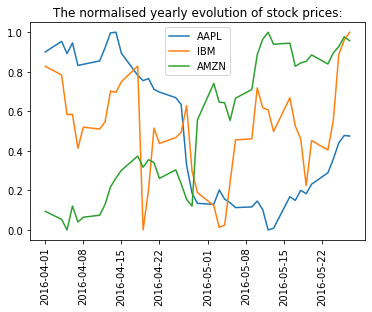

In [5]:
if wiki._data:
    for (cnt, s) in enumerate(stocks):
        min_ = np.min(wiki._data[cnt])
        max_ = np.max(wiki._data[cnt])
        norm = (wiki._data[cnt] - min_)/(max_- min_)
        plt.plot(norm, label=s)
    plt.legend()
    plt.title("The normalised yearly evolution of stock prices:")
    plt.xticks(rotation=90)
    plt.show()
else:
    print('No wiki data loaded.')

Normal distribution parameters

In [6]:
mu = wiki.get_period_return_mean_vector()
sigma = wiki.get_period_return_covariance_matrix()
sigma

array([[2.74263221e-04, 4.69098258e-05, 3.65741318e-05],
       [4.69098258e-05, 1.91773843e-04, 5.16465526e-05],
       [3.65741318e-05, 5.16465526e-05, 4.26822833e-04]])

## Portfolio optimization problem

The mean-variance portfolio optimization problem for $n$ assets is defined as:

$$\min\limits_{x\in\{0,1\}^n}qx^T\Sigma x-\mu^Tx$$

$$\texttt{subject to: }1^Tx=B$$

where:

$x\in\{0,1\}^n$ denotes the vector of binary decision variables, which indicate which assets to pick ($x[i]=1$) and which not to pick ($x[i]=0$),

$\mu\in\mathbb{R}^n$ defines the expected returns for the assets,

$\Sigma\in\mathbb{R}^{n\times n}$ specifies the covariances between the assets,

$q>0$ controls the risk appetite of the decision maker,

$B$ denotes the budget, i.e. the number of assets to be selected out of $n$.

Let's define the variables:

In [7]:
#num of assets (length of out NASDAQ issues array)
num_assets = len(stocks)

# set risk factor
q = 100

# set budget
budget = 2

# set parameter to scale the budget penalty term
penalty = num_assets

We create the problem to solve with the help of the `PortfolioOptimization` class.

We should not worry about transforming the data to create the problem, since the variables `mu` and `sigma` already have it considered.

In [8]:
portfolio = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget)
qp = portfolio.to_quadratic_program()

We define some utility methods to print the results in a nice format.

In [9]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x

def print_result(result):
    selection = result.x
    value = result.fval
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        probability = probabilities[i]
        print('%10s\t%.4f\t\t%.4f' %(x, value, probability))

## Classical Solver: NumPyMinimumEigensolver 

In [10]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result_classical = exact_eigensolver.solve(qp)

print_result(result_classical)

Optimal: selection [1. 1. 0.], value 0.0576

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
   [1 1 0]	0.0576		1.0000
   [1 1 1]	1.2366		0.0000
   [0 1 1]	0.0672		0.0000
   [1 0 1]	0.0749		0.0000
   [0 0 1]	1.1614		0.0000
   [0 1 0]	1.1421		0.0000
   [1 0 0]	1.1527		0.0000
   [0 0 0]	4.4930		0.0000


The optimal solution is that of the minimum value, which indicates that the first and last assets should be chosen, that is, `AAPL` and `IBM`.

**This may vary according to the values of the time series, which change depending on when this notebook is running.**

## VQE Solver

In [11]:
seed = 123

algorithm_globals.random_seed = 1234
backend = Aer.get_backend('statevector_simulator')

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
tl_circuit = TwoLocal(num_assets, 'ry', 'cz', reps=3, entanglement='full')

quantum_instance = QuantumInstance(backend=Aer.get_backend('statevector_simulator'), seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(tl_circuit, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result_vqe = vqe.solve(qp)

print_result(result_vqe)

Optimal: selection [1. 1. 0.], value 0.0576

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
   [1 0 1]	0.0749		0.7436
   [1 1 0]	0.0576		0.2525
   [0 1 1]	0.0672		0.0039
   [1 1 1]	1.2366		0.0000
   [0 0 0]	4.4930		0.0000
   [1 0 0]	1.1527		0.0000
   [0 0 1]	1.1614		0.0000
   [0 1 0]	1.1421		0.0000


Let's see the ansatz circuit used in the VQE solver:

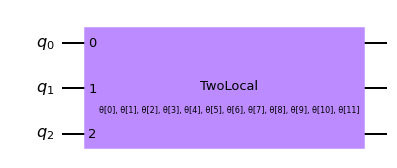

In [12]:
tl_circuit.draw('mpl', f)